# Run Graph Diffusion on PPI Network

In [1]:
import os
import pickle as pk
import gc

import re
import networkx as nx
from scipy import sparse, linalg
import numpy as np
import pandas as pd

import seaborn as sns

In [2]:
top_dir = '../'
inp_dir = os.path.join(top_dir, 'data/preproc/intact_proc')
output_dir = os.path.join(top_dir, 'data/preproc/intact_proc_diffused')
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [3]:
A_df = pd.read_csv(os.path.join(inp_dir, 'A.csv'), index_col=0)

In [4]:
A_df.head()

,SYNJ1,AMPH,SH3GL1,DNM1,FHL2,FHL3,EPS15,MCM7,AR,ABI1,...,CALM3,SFT2D3,SLC16A2,H19,OSBPL7,PDE6A,SCN9A,SLC38A8,MIR146A,MIR338
SYNJ1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AMPH,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SH3GL1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DNM1,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FHL2,0,0,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
nodes = A_df.index.values.astype('str')

In [6]:
A = sparse.csc_matrix(A_df.to_numpy().astype('int32'))
del A_df
gc.collect()

46

In [7]:
# set all diagonals to 0 since we plan on running diffusion with a restart probability
diag_values = A.diagonal()
diag_values[diag_values == 1] = 0
A.setdiag(diag_values)

/home/whitleyo/miniforge3/envs/pytorch3drugcell/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [8]:
# remove anything that doesn't interact with at least one other protein, as this screws up the diffusion calculation
nodes_keep_idx = np.where(np.array(A.sum(axis=1)).flatten() != 0)[0]
nodes_keep = nodes[nodes_keep_idx]
print(len(nodes))
print(len(nodes_keep))
A = A[nodes_keep_idx, :][:, nodes_keep_idx]
gc.collect()

16015
15993


46

In [9]:
A.diagonal()

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [10]:
D1 = sparse.csc_matrix(np.diag(np.array(1/A.sum(axis=1)).flatten()))
gc.collect()

46

In [11]:
D1

<15993x15993 sparse matrix of type '<class 'numpy.float64'>'
	with 15993 stored elements in Compressed Sparse Column format>

In [12]:
D2 =  sparse.csc_matrix(np.diag(np.repeat(1., A.shape[0])))

In [13]:
D2.shape

(15993, 15993)

In [14]:
# Make the Transition Matrix
A1 = 0.5*(D2 + (D1 @ A))

In [15]:
A1.sum(axis=1)

matrix([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])

In [16]:
A1.diagonal()

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [17]:
np.quantile(A1[A1.nonzero()], [0.05, 0.25, 0.5, 0.75, 0.95])

array([0.00168919, 0.00543478, 0.01282051, 0.03571429, 0.5       ])

In [18]:
del A
del D1
del D2
gc.collect()

46

In [19]:
A1.sum(axis=1)

matrix([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])

In [20]:
AN = A1.copy()

In [21]:
# max_eps = 0.01
fraction_edges = [float(A1.count_nonzero())/float(A1.shape[0]**2)]
# fraction_gt_05 = [float(sum(np.array(A1[A1.nonzero()]).flatten() > 0.05))/float(A1.shape[0]**2)]
max_iter = 3
for i in range(0, max_iter):
    AN_next = AN @ A1
    fraction_edges.append(float(AN_next.count_nonzero())/float(AN_next.shape[0]**2))
    # fraction_gt_05.append(float(sum(np.array(AN_next[AN_next.nonzero()]).flatten() > 0.05))/float(AN_next.shape[0]**2))
    # eps = (abs(AN_next - AN)).sum()
    del AN
    gc.collect()
    AN = AN_next
    del AN_next
    gc.collect()
    print('i: {}'.format(i))
    # print("eps {}".format(eps))
    # if eps < max_eps:
    #     break
    # if i + 1 == max_iter:
    #     print('no convergence')

i: 0
i: 1
i: 2


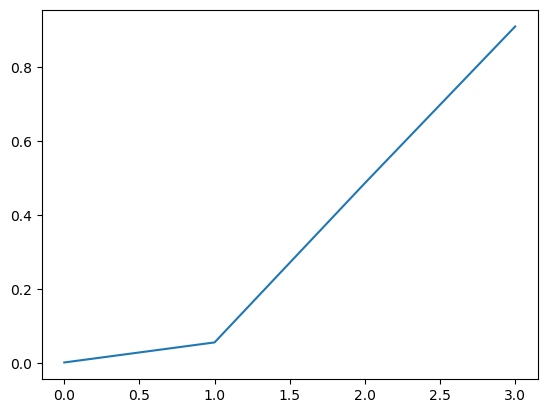

In [22]:
sns.lineplot(x=np.arange(0, max_iter + 1), y=fraction_edges)

In [23]:
fraction_edges

[0.001134214877171709,
 0.055473681196787895,
 0.48676253107655126,
 0.9109954818326246]

In [24]:
# sns.lineplot(x=np.arange(0, max_iter + 1), y=fraction_gt_05)

In [25]:
# fraction_gt_05

In [26]:
del AN
gc.collect()

92

In [27]:
AN = A1.copy()

In [28]:
max_iter = 2
for i in range(0, max_iter):
    AN_next = AN @ A1
    del AN
    gc.collect()
    AN = AN_next
    del AN_next
    gc.collect()
    print('i: {}'.format(i))

i: 0
i: 1


In [29]:
A1

<15993x15993 sparse matrix of type '<class 'numpy.float64'>'
	with 290105 stored elements in Compressed Sparse Column format>

In [30]:
np.quantile(A1[A1.nonzero()], [0.05, 0.25, 0.5, 0.75, 0.95])

array([0.00168919, 0.00543478, 0.01282051, 0.03571429, 0.5       ])

In [31]:
np.quantile(AN[AN.nonzero()], [0.05, 0.25, 0.5, 0.75, 0.95])

array([2.17125754e-07, 1.20917815e-06, 4.20903765e-06, 1.62539867e-05,
       2.10653304e-04])

In [32]:
np.quantile(AN.diagonal(), [0.05, 0.25, 0.5, 0.75, 0.95])

array([0.12765669, 0.13302726, 0.13990385, 0.15183082, 0.19339612])

In [33]:
del A1
gc.collect()

115

In [34]:
AN

<15993x15993 sparse matrix of type '<class 'numpy.float64'>'
	with 124502197 stored elements in Compressed Sparse Column format>

In [35]:
A_df = pd.DataFrame(AN.todense(), index=nodes_keep, columns=nodes_keep)
A_df.to_csv(os.path.join(output_dir, 'A_random_walk_{}_step.csv'.format(max_iter)))